# Calcul parallèle

(Version pour Julia 0.4 ... 0.6 à venir)
JULIA dans sa grande force permet nativement le calcul parallel plus précisément calcul parallel à mémoire partagée ou distribuée.

Le document référence officiel : http://julia.readthedocs.org/en/latest/manual/parallel-computing/

http://www.csd.uwo.ca/~moreno/cs2101a_moreno/Parallel_computing_with_Julia.pdf Très transparants très bien fait la notion de Task est abordée...

http://www.admin-magazine.com/HPC/Articles/Julia-Distributed-Arrays


http://www.admin-magazine.com/HPC/Articles/Parallel-Julia-Jumping-Right-In

http://www.blog.juliaferraioli.com/2014/02/julia-on-google-compute-engine-parallel.html

http://www.alshum.com/parallel-julia/

In [1]:
Pkg.add("PyPlot")
using PyPlot # pour afficher le résultat sur le noeud master

INFO: Package PyPlot is already installed


En tout premier lieu on peut lancer une instance de JULIA avec plusieurs processeurs (ou plusieurs instances de JULIA) à l'aide de la commande shell

julia -p 4

Autrement on peut à la volée ajouter/enlever des processeurs ou plutôt workers à l'aide des commandes <code>addproc()</code> <code>rmproc()</code> et <code>worker()</code> ainsi que les commandes <code>nprocs</code> et <code>nworker</code> 

In [2]:
workers() # par défaut un worker le "maitre"

1-element Array{Int64,1}:
 1

In [3]:
addprocs(2) #ajout de 2 workers

2-element Array{Int64,1}:
 2
 3

In [4]:
workers() # le processeur 1 n'est plus worker il est evenu master

2-element Array{Int64,1}:
 2
 3

# @parallel for

JULIA offre une façon simple de paralleliser une boucle for à l'aide de la macro @parallel

In [5]:
taille=7
@parallel for i=1:taille
    println(myid()); # renvoie le numéro du worker
end;

In [6]:
myid() # numéro du processus maitre

1

Regardons plus exactement la répartition du calcul pour cela utilisons un tableau partagé <code>SharedArray</code> (voir également <code>SharedMatrix</code>, <code>SharedVector</code>). Autrement dit un tableau qui sera accessible en lecture et en écriture pour chaque worker (et le master).

In [7]:
taille=7
a = SharedArray{Int}(1,taille) # Tableau partagé
@parallel for i=1:taille
    a[i]=myid(); # renvoie le numéro du worker stocké dans a
end;

	From worker 2:	2
	From worker 2:	2
	From worker 2:	2
	From worker 2:	2
	From worker 3:	3
	From worker 3:	3
	From worker 3:	3


In [8]:
a

1×7 SharedArray{Int64,2}:
 2  2  2  2  3  3  3

La boucle à été partagée et envoyée pour $i=1:4$ sur le worker 2 et pour $i=5:7$ sur le worker 3.

Regardons si nous n'avions pas utilisé de tableau partagé

In [9]:
taille=7
a = zeros(taille) # Tableau non partagé il est ici en local myid()==1
 @parallel for i=1:taille
    a[i]=myid(); # renvoie le numéro du worker
    println(a)
end;

On peut voire que localement les workers ont accès à une copie de <code>a</code> dont ils peuvent modifier les valeurs "localement". 

Par contre

In [10]:
println(a)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	From worker 2:	[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


la valeur sur master n'a pas été modifiée. Autrement dit chaque worker a utilisé une copie locale de a, localement modifiable mais une fois l'exécution terminée cette copie est effacée.

In [11]:
a = ones(taille)
@parallel for i=1:2
    println(a) # nouvelle copie locale
end;

	From worker 2:	[2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0]
	From worker 2:	[2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0]
	From worker 2:	[2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0]
	From worker 3:	[0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0]


# Application Bassin d'attraction de Newton :

Plaçons nous sur un exemple de calcul de bassin d'attraction de Newton

## premier calcul mono-processeur (temps de référence)

In [12]:
# algorithme de Newton
function newton(x0,f,df,epsi)
    k=0;
    x=x0;
    xnew=x-df(x)\f(x);
    while (norm(x-xnew)>epsi)&(k<1000)
        x=xnew
        xnew=x-df(x)\f(x);
    end
    return xnew
end
# fonction f(x)=0 à résoudre ici z=x+iy et f(z)=z^3-1
f(x)=[x[1]^3-3*x[1]*x[2]^2-1,3*x[1]^2*x[2]-x[2]^3]
# le jacobien de f
df(x)=[3*x[1]^2-3*x[2]^2 -6*x[1]*x[2];6*x[1]*x[2] 3*x[1]^2-3*x[2]^2]

# Calcul du bassin si on converge vers la Ieme racine suivant le point de départ
function calc_bassin(f,df,n)
    x=linspace(-1,1,n);
    y=linspace(-1,1,n);
    Imag=zeros(n,n);
    for i=1:n
        for j=1:n
            r=newton([x[i],y[n-j+1]],f,df,1e-10)
            Imag[j,i]=(round(atan2(r[2],r[1])*3/pi)+3)%3;
        end
    end
    return Imag
end

	From worker 3:	[0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 0.0]
	From worker 3:	[0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0]


calc_bassin (generic function with 1 method)

	From worker 3:	[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
	From worker 2:	[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [13]:
n=512 # un deuxième appel est plus rapide
@time Imag=calc_bassin(f,df,n); 

  4.279615 seconds (43.48 M allocations: 2.050 GiB, 9.95% gc time)


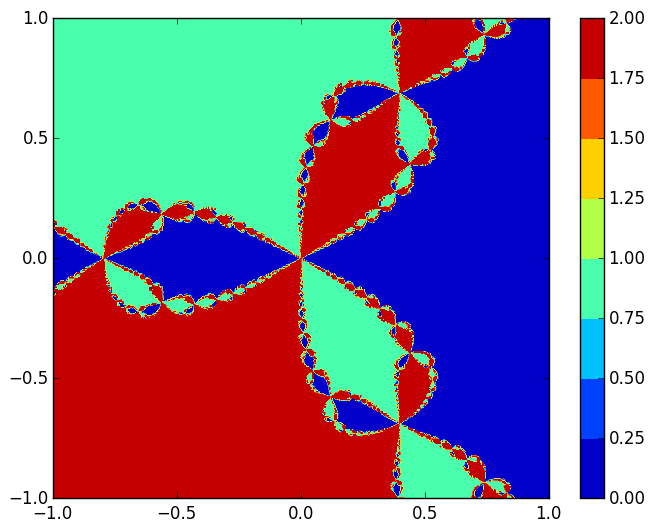

/usr/lib64/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1d888af2d8>

In [14]:
contourf(linspace(-1,1,n),linspace(-1,1,n),Imag)
colorbar()

## Newton en parallèle

In [15]:
addprocs(2); # on ajoute 2 processeurs

Dans un premier temps on redéfinie les fonctions newton, f et df pour tous les workers à l'aide de la macro @everywhere

In [16]:
# algorithme de Newton
@everywhere function newton(x0,f,df,epsi)
    k=0;
    x=x0;
    xnew=x-df(x)\f(x);
    while (norm(x-xnew)>epsi)&(k<1000)
        x=xnew
        xnew=x-df(x)\f(x);
    end
    return xnew
end
# fonction f(x)=0 à résoudre ici z=x+iy et f(z)=z^3-1
@everywhere f(x)=[x[1]^3-3*x[1]*x[2]^2-1,3*x[1]^2*x[2]-x[2]^3]
# le jacobien de f
@everywhere df(x)=[3*x[1]^2-3*x[2]^2 -6*x[1]*x[2];6*x[1]*x[2] 3*x[1]^2-3*x[2]^2]
# Calcul du bassin si on converge vers la Ieme racine suivant le point de départ

Puis on uitlise <code>@parallel</code> dans la boucle extérieure ainsi que <code>@sync</code> pour resynchroniser les process autrement attendre que tous les workers aient fini leurs calculs 

In [17]:
function calc_bassin(f,df,n)
    x=linspace(-1,1,n);
    y=linspace(-1,1,n);
    Imag=SharedArray{Int}(n,n);
    @sync begin
        @parallel for i=1:n
             for j=1:n
                r=newton([x[i],y[n-j+1]],f,df,1e-10)
                Imag[j,i]=(round(atan2(r[2],r[1])*3/pi)+3)%3;
            end
        end
    end
    return Imag
end

calc_bassin (generic function with 1 method)

In [18]:
n=512 # pour efficacité il faut relancer 2 fois
@time Imag=calc_bassin(f,df,n); 

  5.018573 seconds (105.40 k allocations: 5.751 MiB)


In [19]:
4/1.33/nworkers()

0.7518796992481203

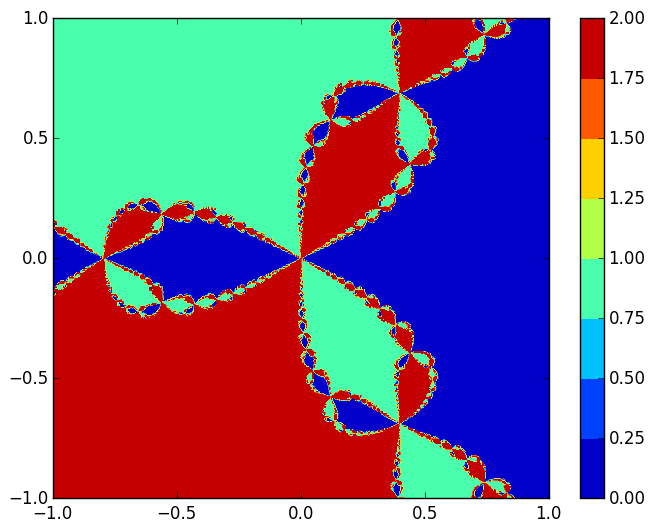

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1d88282dd0>

In [20]:
contourf(linspace(-1,1,n),linspace(-1,1,n),Imag)
colorbar()

# Encore plus de //

On a utilisé les macros <code>@everywhere</code> <code>@parallel</code> <code>@sync</code>
regardons 

* <code>remotecall</code> appel asynchrone (n'attends pas le résultat dit appel non bloquant)
* <code>fetch</code> récupère le résultat (synchronise)
* <code>remotecall_fetch</code> les 2 commandes précédentes réunies ou appel bloquant (tant que le résultat n'est pas calculé la fonction ne rend pas la main.
* <code>remotecall_wait</code> appel bloquant attend la fin de l'éxacution.
* <code>@async</code> exécute le bloc en mode asynchrone.
* <code>@spawn</code> et <code>@spawnat</code> macros pour <code>remotecall</code>

In [21]:
for proc=workers()
    println(remotecall_fetch(proc,myid)) # demande l'exécution de myid() sur chaque proc
end

LoadError: [91mMethodError: no method matching remotecall_fetch(::Int64, ::Base.Distributed.#myid)[0m
Closest candidates are:
  remotecall_fetch(::Any, [91m::Base.Distributed.LocalProcess[39m, [91m::Any...[39m; kwargs...) at distributed/remotecall.jl:339
  remotecall_fetch(::Any, [91m::Base.Distributed.Worker[39m, [91m::Any...[39m; kwargs...) at distributed/remotecall.jl:346
  remotecall_fetch(::Any, [91m::Integer[39m, [91m::Any...[39m; kwargs...) at distributed/remotecall.jl:367
  ...[39m

In [22]:
a=zeros(nworkers())
for i=1:nworkers()
    a[i]=remotecall_fetch(i+1,myid)
end
println(a) # a contien les numéros des workers  

LoadError: [91mMethodError: no method matching remotecall_fetch(::Int64, ::Base.Distributed.#myid)[0m
Closest candidates are:
  remotecall_fetch(::Any, [91m::Base.Distributed.LocalProcess[39m, [91m::Any...[39m; kwargs...) at distributed/remotecall.jl:339
  remotecall_fetch(::Any, [91m::Base.Distributed.Worker[39m, [91m::Any...[39m; kwargs...) at distributed/remotecall.jl:346
  remotecall_fetch(::Any, [91m::Integer[39m, [91m::Any...[39m; kwargs...) at distributed/remotecall.jl:367
  ...[39m

In [23]:
for i=1:10
    r = @spawn myid() 
    println("process: $(r.where) int: $(fetch(r))")  
end  

process: 2 int: 2
process: 3 int: 3
process: 4 int: 4
process: 5 int: 5
process: 2 int: 2
process: 3 int: 3
process: 4 int: 4
process: 5 int: 5
process: 2 int: 2
process: 3 int: 3


## Newton parallel 2

Reprenons notre algorithme de calcul de bassin

In [24]:
# Calcul du bassin si on converge vers la Ieme racine suivant le point de départ
function calc_bassin_async(f,df,n)
    x=linspace(-1,1,n);
    y=linspace(-1,1,n);
    Imag=zeros(n,n);
    k=0
    wo=workers()
    nw=nworkers()
    @sync begin
        for i=1:n
            for j=1:n
                @async begin    # lancement asynchrone      
                    k=k+1
                    wk=wo[k%nw+1] # worker suivant
                    r=remotecall_fetch(wk,newton,[x[i],y[n-j+1]],f,df,1e-10)
                    Imag[j,i]=(round(atan2(r[2],r[1])*3/pi)+3)%3;
            end # ens @async
            end
        end     
    end # end @sync
    return Imag
end

calc_bassin_async (generic function with 1 method)

In [25]:
n=32 # efficacité pas très grande voir catastrophique !
@time Imag=calc_bassin_async(f,df,n); 

LoadError: [91m[91mMethodError: no method matching remotecall_fetch(::Int64, ::#newton, ::Array{Float64,1}, ::#f, ::#df, ::Float64)[0m
Closest candidates are:
  remotecall_fetch(::Any, [91m::Base.Distributed.LocalProcess[39m, ::Any...; kwargs...) at distributed/remotecall.jl:339
  remotecall_fetch(::Any, [91m::Base.Distributed.Worker[39m, ::Any...; kwargs...) at distributed/remotecall.jl:346
  remotecall_fetch(::Any, [91m::Integer[39m, ::Any...; kwargs...) at distributed/remotecall.jl:367
  ...[39m
macro expansion at ./In[24]:15 [inlined]
(::##25#26{#f,#df,Int64,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Float64,2},Array{Int64,1},Int64})() at ./task.jl:335

...and 1023 more exception(s).
[39m

On peut voir que le code n'est pas très efficace on perd beaucoup de temps en communication on fait trop d'appels aux workers ($n^2$).

Changeons de principe et divisons la tache en nombre de workers :

In [26]:
# résoltion d'un block du probleme du bassin de Newtown
@everywhere function calc_block(f,df,x,y)
    n=length(x)
    m=length(y)
    Imag=zeros(m,n)
    for i=1:n
        for j=1:m
            r=newton([x[i],y[m-j+1]],f,df,1e-10)
            Imag[j,i]=(round(atan2(r[2],r[1])*3/pi)+3)%3;
        end
    end
    return Imag
end

In [27]:
function calc_bassin_parallel(f,df,n)
    x=linspace(-1,1,n);
    y=linspace(1,-1,n);
    Imag=zeros(n,n); 
    
    # permet la répartition du travail
    wo=workers()
    nw=nworkers()
    part=[round(n/nw) for i = 1:nw]
    rest=round(Int,nw*part[1]-n);
    part[1:rest]+=1;
    part=cumsum(part);
    part=round(Int,[0;part])
    
    @sync for i=1:nw # répartition sur tous les workers
        @async begin  
            Imag[:,part[i]+1:part[i+1]]=
                remotecall_fetch(wo[i],calc_block,f,df,x[part[i]+1:part[i+1]],y)
            end # end @async
    end     
    return Imag
end

calc_bassin_parallel (generic function with 1 method)

In [28]:
n=512 # efficacité correcte 
@time Imag=calc_bassin_parallel(f,df,n); 

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Type{Int64}, ::Array{Float64,1}) at ./deprecated.jl:57
 [3] calc_bassin_parallel(::Function, ::Function, ::Int64) at ./In[27]:13
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] include_string(::Module, ::String, ::String) at /home/clope/.julia/v0.6/Compat/src/Compat.jl:174
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/clope/.julia/v0.6/IJulia/src/execute_request.jl:158
 [7] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/clope/.julia/v0.6/Compat/src/Compat.jl:488
 [8] eventloop(::ZMQ.Socket) at /home/clope/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[28], in expression starting on line 237


LoadError: [91m[91mMethodError: no method matching remotecall_fetch(::Int64, ::#calc_block, ::#f, ::#df, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}, ::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}})[0m
Closest candidates are:
  remotecall_fetch(::Any, [91m::Base.Distributed.LocalProcess[39m, ::Any...; kwargs...) at distributed/remotecall.jl:339
  remotecall_fetch(::Any, [91m::Base.Distributed.Worker[39m, ::Any...; kwargs...) at distributed/remotecall.jl:346
  remotecall_fetch(::Any, [91m::Integer[39m, ::Any...; kwargs...) at distributed/remotecall.jl:367
  ...[39m
macro expansion at ./In[27]:17 [inlined]
(::##32#34{#f,#df,StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Float64,2},Array{Int64,1}})() at ./task.jl:335

...and 3 more exception(s).
[39m

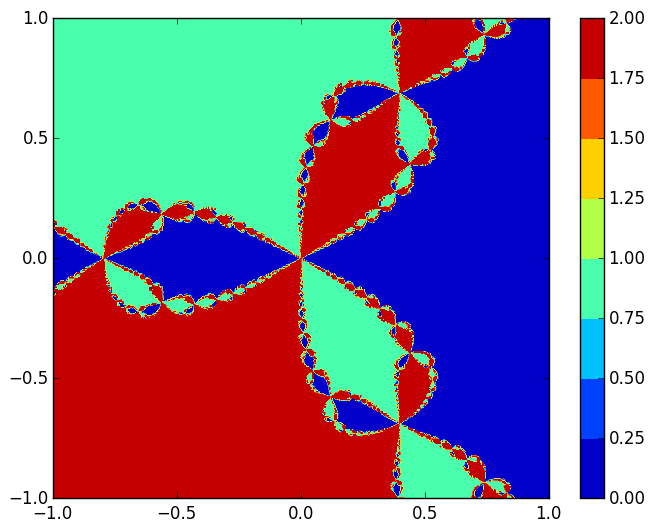

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f1d80c07950>

In [29]:
contourf(linspace(-1,1,n),linspace(-1,1,n),Imag)
colorbar()

En diminuant le nombre d'appels on à retrouver une efficacité de l'ordre de 88% $\left(\dfrac{T_{ref}}{T_{multiproc} * nbproc}\right)$ comme avec la macro <code>@parallel</code> précédente.

# Package ParallelAccelerator

Un peu comme pour Pythran il existe un package assez interressant mais avec tout de suite des limites : voir http://julialang.org/blog/2016/03/parallelaccelerator



In [30]:
Pkg.add("ParallelAccelerator")

INFO: Package ParallelAccelerator is already installed


In [31]:
using ParallelAccelerator

In [32]:
@acc begin
    # algorithme de Newton séquentiel
    function newton(x0,f,df,epsi)
        k=0;
        x=x0;
        xnew=x-df(x)\f(x);
        while (norm(x-xnew)>epsi)&(k<1000)
            x=xnew
            xnew=x-df(x)\f(x);
        end
        return xnew
    end
    # fonction f(x)=0 à résoudre ici z=x+iy et f(z)=z^3-1
    f(x)=[x[1]^3-3*x[1]*x[2]^2-1,3*x[1]^2*x[2]-x[2]^3]
    # le jacobien de f
    df(x)=[3*x[1]^2-3*x[2]^2 -6*x[1]*x[2];6*x[1]*x[2] 3*x[1]^2-3*x[2]^2]

    # Calcul du bassin si on converge vers la Ieme racine suivant le point de départ
    function calc_bassin(f,df,n)
        x=linspace(-1,1,n);
        y=linspace(-1,1,n);
        Imag=zeros(n,n);
        for i=1:n
            for j=1:n
                r=newton([x[i],y[n-j+1]],f,df,1e-10)
                Imag[j,i]=(round(atan2(r[2],r[1])*3/pi)+3)%3;
            end
        end
        return Imag
    end
end

calc_bassin (generic function with 1 method)

In [33]:
n=512 # un deuxième appel est plus rapide
@time Imag=calc_bassin(f,df,n); 

LoadError: [91mTypeError: ccall: expected Symbol, got Base.Math.#atan2[39m